# Importing Packages Needed

In [1]:
import numpy as np

In [2]:
import scipy as sp

In [3]:
import matplotlib.pyplot as py

In [4]:
from scipy.optimize import curve_fit

In [5]:
from scipy.signal import find_peaks

In [6]:
import collections as col

In [7]:
import statistics

In [8]:
from scipy.interpolate import UnivariateSpline

# Definition of Named Tuples

In [9]:
component = col.namedtuple('component','phase intensity')

In [10]:
ind_component = col.namedtuple('component','phase intensity width')

In [11]:
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')

In [12]:
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [13]:
def gauss(x,cen,sd,amp):
    return amp*np.exp(-(x-cen)**2/2/sd**2)

def twogauss(x,cen1,sd1,amp1,cen2,sd2,amp2):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)

def threegauss(x,cen1,sd1,amp1,cen2,sd2,amp2,cen3,sd3,amp3):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)+gauss(x,cen3,sd3,amp3)

def fourgauss(x,cen1,sd1,amp1,cen2,sd2,amp2,cen3,sd3,amp3,cen4,sd4,amp4):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)+gauss(x,cen3,sd3,amp3)+gauss(x,cen4,sd4,amp4)

In [14]:
def fittingtwo_parameters(x,y,expected):
    params,cov=curve_fit(twogauss,x,y,expected, bounds=([0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    sigma=np.sqrt(np.diag(cov))
    return params, sigma

def fittingfour_parameters(x,y,expected):
    params,cov=curve_fit(fourgauss,x,y,expected, bounds=([0,0,0,0,0,0,0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    sigma=np.sqrt(np.diag(cov))
    return params, sigma

In [15]:
def fitting_parameters(x,y,expected):
    params,cov=curve_fit(threegauss,x,y,expected, bounds=([0,0,0,0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    sigma=np.sqrt(np.diag(cov))
    return params, sigma

Finding Peak of Fittings Function

In [16]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Sigma clipping operation:
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.

    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            #print("Took {0} trials to reach tolerance".format(trial+1))
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            #print("Reached number of trials without reaching tolerance level")
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

In [17]:
def find_minima_maxima(x, profile):
    """
    Finds all minima and maxima of the input profile. Assumes that the profile has noise zero-clipped.
    profile: list
        The profile with noise zero-clipped
    Returns:
    --------
    minima: list
        A list of floats corresponding to the bin location of the profile minima
    maxima: list
        A list of floats corresponding to the bin location of the profile maxima
        
    Created by Keegan Smith, edited by Lisa Smith
    """
    maxima=[]
    minima=[]

    #x = np.linspace(0, 1024, 1024, dtype=int)
    spline = UnivariateSpline(x, profile, s=0.0, k=4)
    comp_roots = spline.derivative().roots()
    # These are the roots, we want to split maxima and minima ^^
    for i, root in enumerate(comp_roots):
        idx = int(root)
        left = profile[idx-1]
        if left>profile[idx]:
            minima.append(root)
        else:
            maxima.append(root)
        
    return maxima

In [18]:
def which_peaks(params, peakpos, sigma):
    """
    A really shitty and long way to find out which parameter each peak corresponds to, and assigning the correct errors
    """
    errors=[]
    
    #Finds which of the gaussian fits matches with the detected peak, and assigns the correct errors
    if len(sigma)==12 and abs(peakpos[0]-params[9])<abs(peakpos[0]-params[3]) and abs(peakpos[0]-params[9])<abs(peakpos[0]-params[6]) and (peakpos[0]-params[9])<abs(peakpos[0]-params[0]):
        errors.append(sigma[9])
    elif abs(peakpos[0]-params[0])<abs(peakpos[0]-params[3]) and abs(peakpos[0]-params[0])<abs(peakpos[0]-params[6]):
        errors.append(sigma[0])
    elif abs(peakpos[0]-params[3])<abs(peakpos[0]-params[0]) and abs(peakpos[0]-params[3])<abs(peakpos[0]-params[6]):
        errors.append(sigma[3])
    elif abs(peakpos[0]-params[6])<abs(peakpos[0]-params[0]) and abs(peakpos[0]-params[6])<abs(peakpos[0]-params[3]):
        errors.append(sigma[6])
      
    if len(sigma)==12 and abs(peakpos[1]-params[9])<abs(peakpos[1]-params[3]) and abs(peakpos[1]-params[9])<abs(peakpos[1]-params[6]) and (peakpos[1]-params[9])<abs(peakpos[1]-params[0]):
        errors.append(sigma[9])
    elif abs(peakpos[1]-params[0])<abs(peakpos[1]-params[3]) and abs(peakpos[1]-params[0])<abs(peakpos[1]-params[6]):
        errors.append(sigma[0])
    elif abs(peakpos[1]-params[3])<abs(peakpos[1]-params[0]) and abs(peakpos[1]-params[3])<abs(peakpos[1]-params[6]):
        errors.append(sigma[3])
    elif abs(peakpos[1]-params[6])<abs(peakpos[1]-params[0]) and abs(peakpos[1]-params[6])<abs(peakpos[1]-params[3]):
        errors.append(sigma[6])
        
    return errors

In [19]:
def gauss_peaks(fit, nofreqband, freqband, sigma, params,freq_low,freq_high):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    noise_std: int
        the standard deviation of the noise - the error of the data
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    peakpos = find_minima_maxima(x, fit)
    
    if len(params)==9:
        peakint = threegauss(peakpos, *params)
    elif len(params)==12:
        peakint = fourgauss(peakpos, *params)
    elif len(params)==6:
        peakint = twogauss(peakpos, *params)
    
    while len(peakpos)>2:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        if rm!=0 and rm!=len(peakpos)-1:
            del peakpos[rm]
            del peakint[rm]
        else:
            break
    
    #Finds error of peaks 
    if len(peakpos)==2:
        err = which_peaks(params, peakpos, sigma)
    
    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    if len(peakpos)==2:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        error = np.array(err)*(deg_mod)
        print('Component Phases:', (deg_mod)*peakpos[0], (deg_mod)*peakpos[1])
        print('Separation:',((deg_mod)*peakpos[1])-((deg_mod)*peakpos[0]))
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0

    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband))+freq_low

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

Removing outliers

In [20]:
"""
    Removing outliers operation
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors.
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    
    for i in range(len(phase_comp)):
        z_score= (phase_comp[i] - mean_1)/std_1 
        if np.abs(z_score) < threshold and comp_err[i]<100:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

Plotting Fittings Functions

In [21]:
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

In [22]:
def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    params3 = params[6:9]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    gfit3 = gauss(x, *params3)

    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    py.plot(x, gfit3, "b")
    py.fill_between(x, gfit3.min(), gfit3, facecolor="blue", alpha=0.5)

    return 

In [23]:
def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=1)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [24]:
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    #Go through all the different frequencies
    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            #Subtract second component from first
            sep=(components_array[i][2][0]) - (components_array[i][1][0])
            single_sep=component_separation(frequency=freq, separation=sep)
            sep_array.append(single_sep)
            #Calculate uncertainty
            uncert.append(np.sqrt((components_array[i][3][0])**2 + (components_array[i][3][1])**2))
    return sep_array, uncert

In [25]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)

In [26]:
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

GMRT data

In [27]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [28]:
averageprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/pdv/J0820_s_f28_T_pazi.pdv', dtype=fulldatatype)

In [29]:
#averageprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/f28new/J0820_t20_f28_T.pdv', dtype=fulldatatype)

In [30]:
no_freq_bands = max(averageprofiles['frequency'])+1

MWA data

In [32]:
averagemprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/MWA_f256/J0820_MWA_f256_b4.pdv', dtype=fulldatatype)

In [33]:
nom_freq_bands = max(averagemprofiles['frequency'])+1

Extra data 

In [34]:
highfrequencyprofile = np.loadtxt(fname='../archivefiles/extra_data/J0820-4114.1400MHz.txt', dtype=fulldatatype)

In [36]:
#mwaprofile = np.loadtxt(fname='../archivefiles/extra_data/1139239952_ch133-156_0001_PSR_J0820-4114.pfd.bestprof.txt', dtype=fulldatatype)
mwaprofile = np.loadtxt(fname='../archivefiles/com_archivefiles/MWA_F/J0820_MWA_F_T.pdv', dtype=fulldatatype)

# Gaussian Plotting of Individual Frequency Band 

Following Section is for error checking. 

In [37]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 10
f = averageprofiles['frequency'] == freqband
phase=averageprofiles['phase'][f]
intensity=averageprofiles['intensity'][f]
x = phase
y = intensity

In [38]:
len(y)

1024

In [39]:
#Calculates the noise of the data. The standard deviation of this is then the error in the data. 
noise = sigmaClip(y)
noise_std = np.nanstd(noise[1])
print(noise_std)

1.0405296625746965


In [40]:
#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected=(501,30,8.02,655,80,4.07,741,20,11.29)
#Fits three gaussians to the data
params,sigma = fitting_parameters(x,y,expected)
fit = threegauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, no_freq_bands, freqband, sigma, params,300,500)

Component Phases: 183.18026959469242 260.6564059035226
Separation: 77.4761363088302


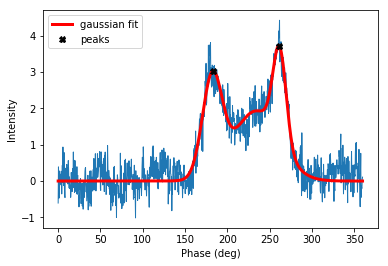

In [41]:
plot_peaks(x*(360/1024),y,profile_comp)

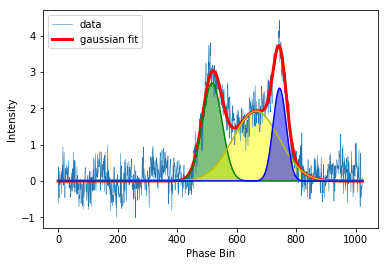

In [42]:
plot_fill(x,y,params)

#### For the EPTA data set

In [43]:
phase=highfrequencyprofile['phase']
intensity=highfrequencyprofile['intensity']
x = phase
y=[]

#Used to bring the data down, to be centred at 0
m=statistics.mean(intensity[600:])
for i in intensity:
    y.append(i-m)

In [44]:
#Calculates the noise of the data. The standard deviation of this is then the error in the data. 
noise = sigmaClip(y)
noise_std = np.nanstd(noise[1])
print(noise_std)

10.47993007576531


In [45]:
#Expected is taken from Peaks and Gaussian fittings of this frequency band
expected=(270,30,25,370,80,20,470,20,20)
params,sigma = fitting_parameters(x,y,expected)
fit = threegauss(x,*params)
profile_comp = gauss_peaks(fit, 1, 0, sigma, params,1396,1397)

Component Phases: 95.92104089831258 160.4212301171401
Separation: 64.50018921882753


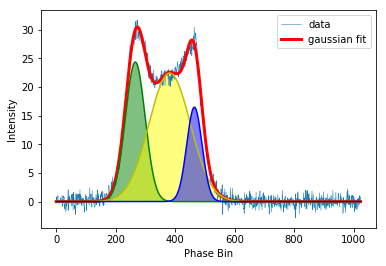

In [46]:
plot_fill(x,y,params)

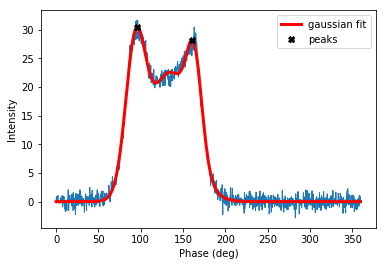

In [47]:
plot_peaks(x*(360/1024),y,profile_comp)

#### MWA Data Set

In [48]:
freqband = 1
f = averagemprofiles['frequency'] == freqband
phase=averagemprofiles['phase'][f]
intensity=averagemprofiles['intensity'][f]
x = phase
y = intensity

In [49]:
len(y)

256

In [50]:
noise = sigmaClip(y)
noise_std = np.nanstd(noise[1])
print(noise_std, noise[0])

0.017404529035323007 0.01866377025674895


In [51]:
#Taken from Peaks and Gaussian fittings of frequency band 11
#1024
#expected=(260,40,0.05,400, 100, 0.02, 495,100,0.02,570,45,0.06)
#128
#expected=(30,7,0.02,50,15,0.01,65,6,0.05,75,6,0.03)
#256
#expected=(65,12,0.04,125,10,0.08)
#expected=(65,12,0.04,100,10,0.01,125,10,0.08)
expected=(65,5,0.015,80,25,0.015,125,5,0.05,150,15,0.03)
#expected=(65,10,0.03,100,25,0.01,150,15,0.04)

In [52]:
params,sigma = fittingfour_parameters(x,y,expected)
fit = fourgauss(x,*params)
profile_comp = gauss_peaks(fit, nom_freq_bands, freqband, sigma, params,170,200)

Component Phases: 93.175828392613 194.43698834964349
Separation: 101.26115995703049


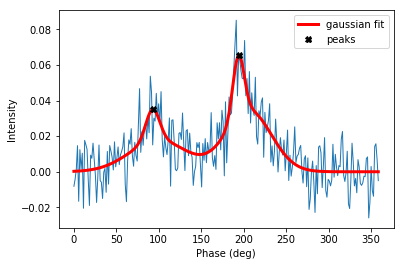

In [53]:
plot_peaks(x*(360/256),y,profile_comp)

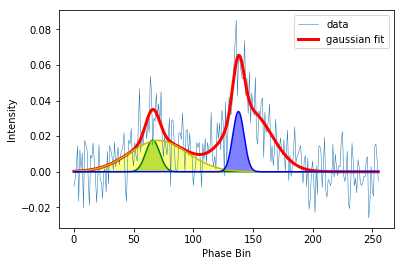

In [54]:
plot_fill(x,y,params)

#### MWA Profile

In [55]:
phase=mwaprofile['phase']
intensity=mwaprofile['intensity']
x = phase
y = intensity

In [56]:
expected=(240,40,0.04,400,100,0.02,575,45,0.06)
params,sigma = fitting_parameters(x,y,expected)
fit = threegauss(x,*params)
profile_comp = gauss_peaks(fit, 1, 0, sigma, params,185,186)

Component Phases: 94.28414310706785 197.548311626465
Separation: 103.26416851939715


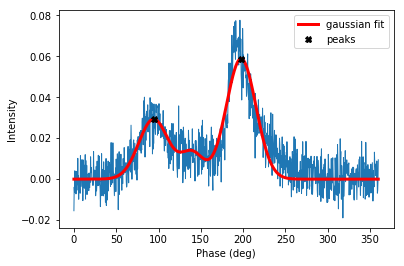

In [57]:
plot_peaks(x*(360/1024),y,profile_comp)

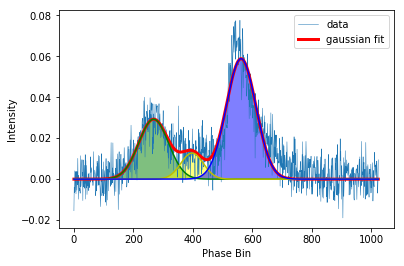

In [58]:
plot_fill(x,y,params)

# Gaussian Plotting and Finding Peaks of Overall Fit


The following is a looped version of the previous section to find the correct peaks for each pulse profile

#### GMRT Data

In [59]:
fit_components = []

In [60]:
#Taken from Peaks and Gaussian fittings of frequency band 73, in the middle
expected=(501,30,8.02,655,80,4.07,741,20,11.29)

#Loop thought all of the frequency bands
for i in range(0,no_freq_bands):
    freqband = i

    f = averageprofiles['frequency'] == freqband
    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]
    
    #Calculates the noise of the data. The standard deviation of this is then the error in the data. 
    noise = sigmaClip(y)
    noise_std = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        params,sigma = fitting_parameters(x,y,expected)
        fit = threegauss(x,*params)
        profile_comp = gauss_peaks(fit, no_freq_bands, freqband, sigma, params, 300, 500)
  
        fit_components.append(profile_comp)

/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Component Phases: 191.27197794790564 262.34764499055905
Separation: 71.07566704265341
Component Phases: 187.27214579198173 261.8516757663086
Separation: 74.57952997432685
Component Phases: 184.448816641162 261.478682460956
Separation: 77.029865819794
Component Phases: 183.18026959469242 260.6564059035226
Separation: 77.4761363088302
Component Phases: 181.89716392244713 259.76927222941987
Separation: 77.87210830697273
Component Phases: 183.1738213235176 259.67693630386793
Separation: 76.50311498035035
Component Phases: 184.7230469031706 261.7795255939918
Separation: 77.05647869082122
Component Phases: 183.4479861601039 260.3633605739282
Separation: 76.91537441382431
Component Phases: 183.60701398170625 260.74147769627234
Separation: 77.1344637145661
Component Phases: 183.73603841247893 261.40702925510965
Separation: 77.67099084263072
Component Phases: 184.07521888550392 261.5204010687941
Separation: 77.4451821832902
Component Phases: 184.1207627676535 261.86135359385196
Separation: 77.7

Component Phases: 173.6146009067807 261.813770185107
Separation: 88.19916927832628
Component Phases: 174.65355568348224 261.55218372513656
Separation: 86.89862804165432
Component Phases: 174.2389008755327 262.0347465194682
Separation: 87.79584564393548
Component Phases: 171.63384446809934 261.8949874423988
Separation: 90.26114297429947
Component Phases: 175.05292695472517 261.333056203307
Separation: 86.28012924858186
Component Phases: 172.96115216003338 261.24946409875537
Separation: 88.28831193872199
Component Phases: 174.35177368033663 261.80987359198673
Separation: 87.4580999116501
Component Phases: 175.47952345142244 261.7930228424905
Separation: 86.31349939106804
Component Phases: 172.2289626552736 262.07431192720253
Separation: 89.84534927192894
Component Phases: 176.21949388457614 262.3793319852808
Separation: 86.15983810070469
Component Phases: 172.31648807276244 260.502106675473
Separation: 88.18561860271055
Component Phases: 173.98999307560723 261.7472963353113
Separation: 8

#### EPTA Data

In [61]:
#Do the above but for only one frequency
expected=(270,30,25,370,80,20,470,20,20)

phase=highfrequencyprofile['phase']
intensity=highfrequencyprofile['intensity']
x = phase
y=[]

m=statistics.mean(intensity[600:])
for i in intensity:
    y.append(i-m)

if len(x)!=0 and len(y)!=0:
    params,sigma = fitting_parameters(x,y,expected)
    fit = threegauss(x,*params)
    profile_compsh = gauss_peaks(fit, 1, 0, sigma, params,1396,1397)

Component Phases: 95.92104089831258 160.4212301171401
Separation: 64.50018921882753


#### MWA Data

In [62]:
fitm_components = []

In [63]:
#Taken from Peaks and Gaussian fittings of frequency band 11, in the middle
expected=(65,5,0.015,80,25,0.015,125,5,0.05,150,15,0.03)
#1024
#expected=(260,40,0.05,400, 100, 0.02, 495,100,0.02,570,45,0.06)
#Loop thought all of the frequency bands
for i in reversed(range(0,nom_freq_bands)):
    freqband = i
    
    f = averagemprofiles['frequency'] == freqband
    x=averagemprofiles['phase'][f]
    y=averagemprofiles['intensity'][f]
    
    freqband = nom_freq_bands-1-i
    
    #Calculates the noise of the data. The standard deviation of this is then the error in the data.
    noise = sigmaClip(y)
    noise_std = noise[0]

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        params,sigma = fittingfour_parameters(x,y,expected)
        fit = fourgauss(x,*params)
        profile_comp = gauss_peaks(fit, nom_freq_bands, freqband, sigma, params,169.6,200.32)
  
        fitm_components.append(profile_comp)

Component Phases: 94.18175557030618 192.70873427979174
Separation: 98.52697870948556
Component Phases: 98.48187798239726 194.59492699763254
Separation: 96.11304901523528
Component Phases: 86.10963825688395 192.03595030260263
Separation: 105.92631204571867
Component Phases: 89.88763322443148 196.60872554855266
Separation: 106.72109232412117
Component Phases: 93.377103843656 191.5248084441073
Separation: 98.14770460045129
Component Phases: 89.0808482479982 191.7583356969212
Separation: 102.67748744892299
Component Phases: 77.82321816237275 189.05201372511846
Separation: 111.2287955627457
Component Phases: 88.74877048667906 190.95969981636998
Separation: 102.21092932969091
Component Phases: 93.175828392613 194.43698834964349
Separation: 101.26115995703049
Component Phases: 86.1966084476181 192.75875756404662
Separation: 106.56214911642851


#### MWA Profile

In [64]:
#Do the above but for only one frequency
expected=(240,40,0.04,400,100,0.02,575,45,0.06)

phase=mwaprofile['phase']
intensity=mwaprofile['intensity']
x = phase
y = intensity

if len(x)!=0 and len(y)!=0:
    params,sigma = fitting_parameters(x,y,expected)
    fit = threegauss(x,*params)
    profile_compm = gauss_peaks(fit, 1, 0, sigma, params,185,186)

Component Phases: 94.28414310706785 197.548311626465
Separation: 103.26416851939715


# Change of Peak Position over Frequency

Starting to graph out all the movement of component phase across frequency

## GMRT

### Component 1

In [65]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp1=[]
frequency_comp1=[]
comp1_err=[]

for i in range(0,len(fit_components)):
    if fit_components[i][1][0] != 0:
        phase_comp1.append(fit_components[i][1][0])
        frequency_comp1.append(fit_components[i][0])
        comp1_err.append(fit_components[i][3][0])

Text(0,0.5,'Frequency')

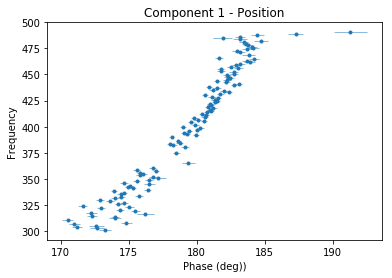

In [66]:
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [67]:
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,2)

Text(0,0.5,'Frequency')

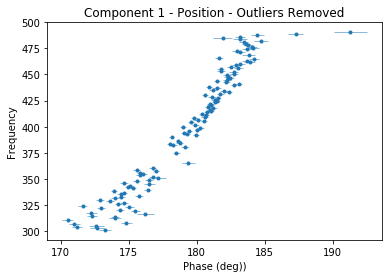

In [68]:
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position - Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [69]:
#Fit the thorsett model to the component position
expect=(500,0.4,16)
comp1_params,comp1_cov=curve_fit(thorsett,frequency_comp1,phase_comp1, expect, maxfev=100000, sigma=comp1_err, bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]))
comp1_fit_error=np.sqrt(np.diag(comp1_cov))
comp1_fit = thorsett(frequency_comp1, *comp1_params)
#Fit a powerlaw to component position
comp1_paramspl,comp1_covpl=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorpl=np.sqrt(np.diag(comp1_covpl))
comp1_fitpl = powerlaw(frequency_comp1, *comp1_paramspl)

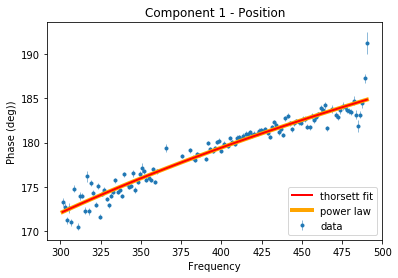

In [70]:
py.errorbar(frequency_comp1, phase_comp1, yerr=comp1_err, fmt='.', lw=0.5, label='data', zorder=0)
py.plot(frequency_comp1,comp1_fit, color='red',lw=2,label='thorsett fit', zorder=2)
py.plot(frequency_comp1,comp1_fitpl, color='orange',lw=4, label='power law', zorder=1)
py.title('Component 1 - Position')
py.ylabel('Phase (deg))')
py.xlabel('Frequency')
py.legend(loc='lower right')

In [71]:
print(f'The thorsett equation of fit for this pulse is: \t Phase = {comp1_params[0]:.3f} \u03BD^{comp1_params[1]:.3f} + {comp1_params[2]:.3f}')
print(f'The errors are {comp1_fit_error[0]}, {comp1_fit_error[1]}, {comp1_fit_error[2]} \n')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramspl[0]:.3f} \u03BD^{comp1_paramspl[1]:.3f}')
print(f'The errors are {comp1_fit_errorpl[0]}, {comp1_fit_errorpl[1]}')

The thorsett equation of fit for this pulse is: 	 Phase = 74.660 ν^0.146 + 0.000
The errors are 350.76162985066185, 0.36734088606381526, 448.02445495282535 

The power law equation of fit for this pulse is: 	 Phase = 74.660 ν^0.146
The errors are 1.396378549046446, 0.003129708595293907


### Component 2

In [72]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp2=[]
frequency_comp2=[]
comp2_err=[]

for i in range(0,len(fit_components)):
    if fit_components[i][2][0] != 0:
        phase_comp2.append(fit_components[i][2][0])
        frequency_comp2.append(fit_components[i][0])
        comp2_err.append(fit_components[i][3][1])

Text(0,0.5,'Frequency')

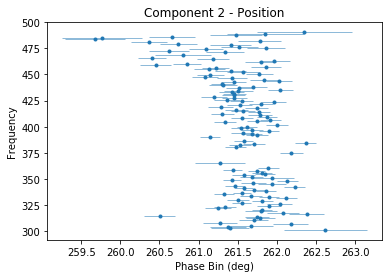

In [73]:
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Position')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [74]:
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,2)

Text(0,0.5,'Frequency')

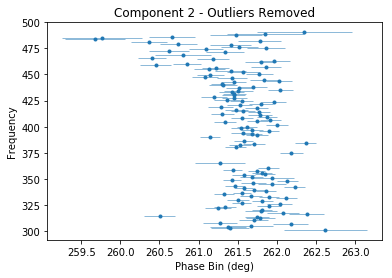

In [75]:
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Outliers Removed')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [76]:
#Fit the thorsett model to the component position
expect=(700,0.4,16)
comp2_params,comp2_cov=curve_fit(thorsett,frequency_comp2,phase_comp2, expect, maxfev=10000, sigma=comp2_err, bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]))
comp2_fit_error=np.sqrt(np.diag(comp2_cov))
comp2_fit = thorsett(frequency_comp2, *comp2_params)
#Fit a powerlaw to the component position
comp2_paramspl,comp2_covpl=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorpl=np.sqrt(np.diag(comp2_covpl))
comp2_fitpl = powerlaw(frequency_comp2, *comp2_paramspl)

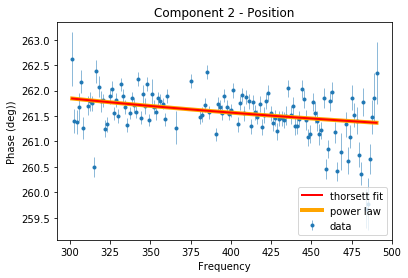

In [77]:
py.errorbar(frequency_comp2, phase_comp2, yerr=comp2_err, fmt='.', lw=0.5, label='data', zorder=0)
py.plot(frequency_comp2,comp2_fit, color='red',lw=2,label='thorsett fit', zorder=2)
py.plot(frequency_comp2,comp2_fitpl, color='orange',lw=4, label='power law', zorder=1)
py.title('Component 2 - Position')
py.ylabel('Phase (deg))')
py.xlabel('Frequency')
py.legend(loc='lower right')

In [78]:
print(f'The thorsett equation of fit for this pulse is: \t Phase = {comp2_params[0]:.3f} \u03BD^{comp2_params[1]:.3f} + {comp2_params[2]:.3f}')
print(f'The errors are {comp2_fit_error[0]}, {comp2_fit_error[1]}, {comp2_fit_error[2]} \n')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramspl[0]:.3f} \u03BD^{comp2_paramspl[1]:.3f}')
print(f'The errors are {comp2_fit_errorpl[0]}, {comp2_fit_errorpl[1]}')

The thorsett equation of fit for this pulse is: 	 Phase = 267.500 ν^-0.004 + 0.000
The errors are 305617.20055462065, 4.37478628206548, 305694.09214726824 

The power law equation of fit for this pulse is: 	 Phase = 267.500 ν^-0.004
The errors are 1.4708607890251801, 0.0009238652771843263


## MWA

## Component 1

In [79]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phasem_comp1=[]
frequencym_comp1=[]
comp1m_err=[]

for i in range(0,len(fitm_components)):
    if fitm_components[i][1][0] != 0:
        phasem_comp1.append(fitm_components[i][1][0])
        frequencym_comp1.append(fitm_components[i][0])
        comp1m_err.append(fitm_components[i][3][0])

Text(0,0.5,'Frequency')

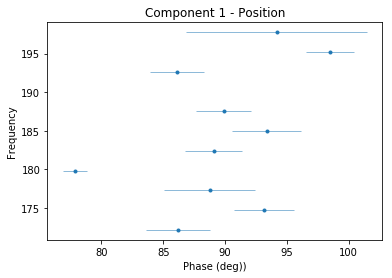

In [80]:
py.errorbar(phasem_comp1,frequencym_comp1, xerr=comp1m_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [81]:
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequencym_comp1, phasem_comp1, comp1m_err = detect_outlier(frequencym_comp1, phasem_comp1, comp1m_err, 2)

Text(0,0.5,'Frequency')

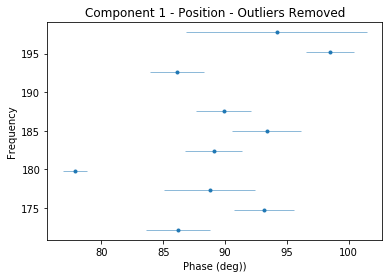

In [82]:
py.errorbar(phasem_comp1,frequencym_comp1, xerr=comp1m_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position - Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [83]:
expect=(500,0.4,16)
comp1m_params,comp1m_cov=curve_fit(thorsett,frequencym_comp1,phasem_comp1, maxfev=100000, sigma=comp1m_err)
comp1m_fit_error=np.sqrt(np.diag(comp1m_cov))
comp1m_fit = thorsett(frequencym_comp1, *comp1m_params)

### Component 2

In [84]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phasem_comp2=[]
frequencym_comp2=[]
comp2m_err=[]

for i in range(0,len(fitm_components)):
    if fitm_components[i][2][0] != 0:
        phasem_comp2.append(fitm_components[i][2][0])
        frequencym_comp2.append(fitm_components[i][0])
        comp2m_err.append(fitm_components[i][3][1])

Text(0,0.5,'Frequency')

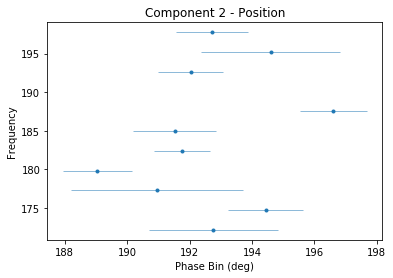

In [85]:
py.errorbar(phasem_comp2,frequencym_comp2, xerr=comp2m_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Position')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [86]:
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequencym_comp2, phasem_comp2, comp2m_err = detect_outlier(frequencym_comp2, phasem_comp2, comp2m_err,2 )

Text(0,0.5,'Frequency')

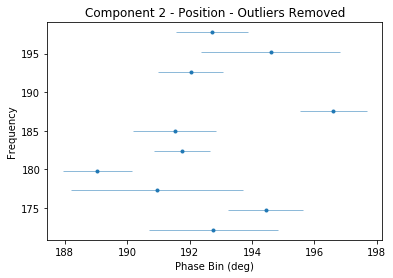

In [87]:
py.errorbar(phasem_comp2,frequencym_comp2, xerr=comp2m_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Position - Outliers Removed')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [88]:
#expect=(700,0.4,16)
comp2m_params,comp2m_cov=curve_fit(thorsett,frequencym_comp2,phasem_comp2, maxfev=10000, sigma=comp2m_err, bounds=([0,-1,0],[1000,0.5,np.inf]))
comp2m_fit_error=np.sqrt(np.diag(comp2m_cov))
comp2m_fit = thorsett(frequencym_comp2, *comp2m_params)

# Fitting Power Laws to Separation 

## Just GMRT

In [89]:
component_sep, sep_error = separation_singleprofile(fit_components)

In [90]:
comp_sep=[]
frequency_forsep=[]

#range(0,no_freq_bands)
for i in range(0,len(component_sep)):
    comp_sep.append(component_sep[i][1])
    frequency_forsep.append(component_sep[i][0])

Text(0,0.5,'Δθ (deg)')

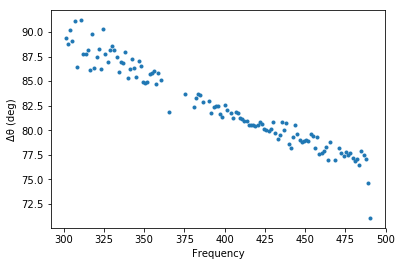

In [91]:
py.plot(frequency_forsep, comp_sep, '.')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [92]:
frequency_forsep, comp_sep, sep_error = detect_outlier(frequency_forsep, comp_sep, sep_error, 2.5)

Text(0,0.5,'Δθ (deg)')

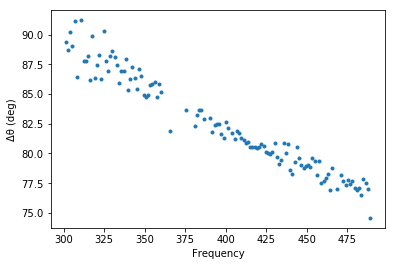

In [93]:
py.plot(frequency_forsep, comp_sep, '.')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [94]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

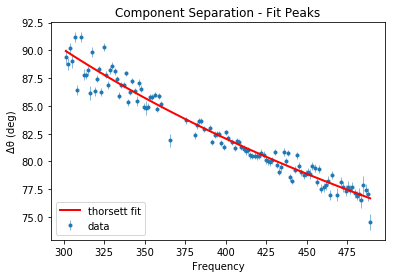

In [95]:
#py.plot(frequency_forsep, comp_sep, '.', label='data')
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='thorsett fit',zorder=2)
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')


In [96]:
#chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 442.623 ν^-0.171 + -76.726 

The errors are 18.753, 0.350, 327.190 
Units for Δθ is degrees and ν is MHz


##  MWA and GMRT

In [97]:
y_sep=comp_sep.copy()
x_sep=frequency_forsep.copy()
err_sep=sep_error.copy()

In [98]:
componentm_sep, sepm_error = separation_singleprofile(fitm_components)

In [99]:
compm_sep=[]
frequencym_forsep=[]

In [100]:
for i in range(0,len(componentm_sep)):
    compm_sep.append(componentm_sep[i][1])
    frequencym_forsep.append(componentm_sep[i][0])

In [101]:
#frequencym_forsep, compm_sep, sepm_error = detect_outlier(frequencym_forsep, compm_sep, sepm_error, 1)

In [102]:
for j in range(0,len(compm_sep)):
    comp_sep.append(compm_sep[j])
    frequency_forsep.append(frequencym_forsep[j])
    sep_error.append(sepm_error[j])

In [103]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

## GMRT/MWA/EPTA

In [104]:
h_fit_components=[]

In [105]:
h_fit_components.insert(0,profile_compsh)

In [106]:
h_component_sep,h_sep_error = separation_singleprofile(h_fit_components)

In [107]:
comp_sep.insert(0,h_component_sep[0][1])
frequency_forsep.insert(0,h_component_sep[0][0])
sep_error.insert(0, h_sep_error[0])

In [108]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-np.inf,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

In [109]:
sepa_fit=[]
x_sepa_fit=list(range(100,1400))
sepa_fit_errors=[]
for i in x_sepa_fit:
    sepa_fit.append(sep_params[0]*(i**(sep_params[1]))+sep_params[2])
    sepa_fit_errors.append(np.sqrt(((i**(sep_params[1])*(sep_fit_error[0]))**2)+(((np.log(i)*sep_params[0]*i**(sep_params[1]))*(sep_fit_error[1]))**2)+((1*(sep_fit_error[2]))**2)))

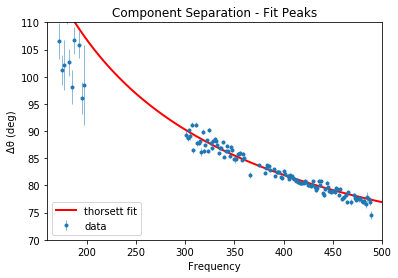

In [110]:
#py.plot(frequency_forsep, comp_sep, '.', label='data')
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
#py.axis((290,500,70,95))
py.axis((160,500,70,110))
#py.axis((125,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

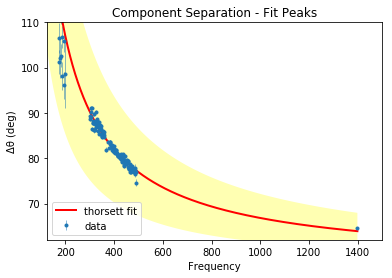

In [111]:
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
py.fill_between(x_sepa_fit, np.array(sepa_fit) - np.array(sepa_fit_errors), np.array(sepa_fit) + np.array(sepa_fit_errors), facecolor='yellow', alpha=0.3)
#py.axis((290,500,70,95))
#py.axis((160,500,70,110))
py.axis((125,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

In [112]:
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 9284.543 ν^-0.985 + 56.490 

The errors are 2753.401, 0.058, 1.357 
Units for Δθ is degrees and ν is MHz


### GMRT, PARKES and MWA Profile

In [113]:
y_sep.insert(0,h_component_sep[0][1])
x_sep.insert(0,h_component_sep[0][0])
err_sep.insert(0, h_sep_error[0])

In [114]:
m_fit_components=[]
m_fit_components.insert(0,profile_compm)
m_component_sep,m_sep_error = separation_singleprofile(m_fit_components)

In [115]:
m_component_sep

[component_separation(frequency=186.0, separation=103.26416851939715)]

In [116]:
y_sep.append(m_component_sep[0][1])
x_sep.append(m_component_sep[0][0])
err_sep.append(m_sep_error[0])

In [117]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,x_sep,y_sep, expect, sigma=err_sep, maxfev=10000,  bounds=([0,-np.inf,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

In [118]:
sepa_fit=[]
x_sepa_fit=list(range(100,1400))
sepa_fit_errors=[]
for i in x_sepa_fit:
    sepa_fit.append(sep_params[0]*(i**(sep_params[1]))+sep_params[2])
    sepa_fit_errors.append(np.sqrt(((i**(sep_params[1])*(sep_fit_error[0]))**2)+(((np.log(i)*sep_params[0]*i**(sep_params[1]))*(sep_fit_error[1]))**2)+((1*(sep_fit_error[2]))**2)))

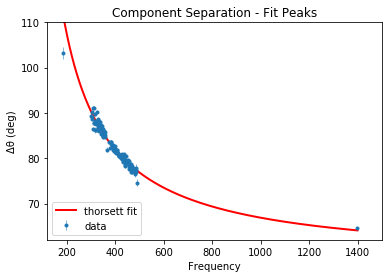

In [119]:
#py.plot(frequency_forsep, comp_sep, '.', label='data')
py.errorbar(x_sep, y_sep, yerr=err_sep, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
#py.axis((290,500,70,95))
#py.axis((160,500,70,110))
py.axis((120,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

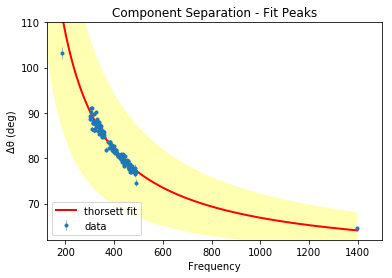

In [120]:
py.errorbar(x_sep, y_sep, yerr=err_sep, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
py.fill_between(x_sepa_fit, np.array(sepa_fit) - np.array(sepa_fit_errors), np.array(sepa_fit) + np.array(sepa_fit_errors), facecolor='yellow', alpha=0.3)
#py.axis((290,500,70,95))
#py.axis((160,500,70,110))
py.axis((125,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

In [121]:
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 11876.437 ν^-1.031 + 57.308 

The errors are 3856.229, 0.063, 1.328 
Units for Δθ is degrees and ν is MHz


# Change in Intensity over Frequency

## Fit Peaks (fit_components)

In [122]:
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])

Text(0,0.5,'Intensity')

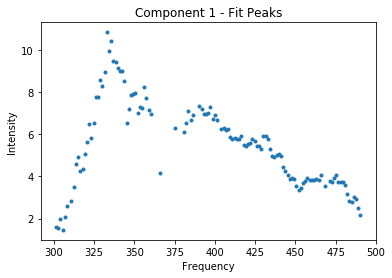

In [123]:
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1 - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

In [124]:
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

Text(0,0.5,'Intensity')

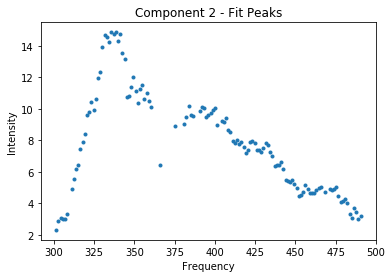

In [125]:
py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2 - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

# Intensity Fitting

In [126]:
int1_params,int1_cov=curve_fit(thorsett,frequency_ind1,intensity_ind1, maxfev=10000)
int1_error=np.sqrt(np.diag(int1_cov))

NameError: name 'frequency_ind1' is not defined

In [ ]:
int1_fit = thorsett(frequency_ind1, *int1_params)

In [ ]:
py.plot(frequency_ind1, intensity_ind1, lw=0.5, label='data')
py.plot(frequency_ind1, int1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [ ]:
int2_params,int2_cov=curve_fit(thorsett,frequency_ind2,intensity_ind2, maxfev=10000)
int2_error=np.sqrt(np.diag(int2_cov))

In [ ]:
int2_fit = thorsett(frequency_ind2, *int2_params)

In [ ]:
py.plot(frequency_ind2, intensity_ind2, lw=0.5, label='data')
py.plot(frequency_ind2, int1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

# Change in Width over Frequency

In [ ]:
width_ind1=[]
frequency_ind1=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    width_ind1.append(ind_components[i][1][2])
    frequency_ind1.append(ind_components[i][0])

In [ ]:
py.plot(frequency_ind1,width_ind1, '.')
py.title('Component 1 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Width (deg)')

In [ ]:
width_ind2=[]
frequency_ind2=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    width_ind2.append(ind_components[i][2][2])
    frequency_ind2.append(ind_components[i][0])

In [ ]:
py.plot(frequency_ind2,width_ind2, '.')
py.title('Component 2 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Width (deg)')

# Width Fitting

In [ ]:
wid1_params,wid1_cov=curve_fit(thorsett,frequency_ind1,width_ind1, maxfev=10000)
wid1_error=np.sqrt(np.diag(wid1_cov))

In [ ]:
wid1_fit = thorsett(frequency_ind1, *wid1_params)

In [ ]:
py.plot(frequency_ind1, width_ind1, lw=0.5, label='data')
py.plot(frequency_ind1,wid1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [ ]:
wid2_params,wid2_cov=curve_fit(thorsett,frequency_ind2,width_ind2, maxfev=10000)
wid2_error=np.sqrt(np.diag(wid2_cov))

In [ ]:
wid2_fit = thorsett(frequency_ind2, *wid2_params)

In [ ]:
py.plot(frequency_ind2, width_ind2, lw=0.5, label='data')
py.plot(frequency_ind2, wid2_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')